# Procesamiento de bases de indicadores

Este notebook documenta el proceso para obtener las bases de indicadores.

* Asociar datos del censo con cartografía de manzanas
* Asignar ids de cuadrante y colonia a las manzanas
* Agregar manzanas a la base de datos (GeoPackage)
* Construcción de agregados de variables por unidades

In [ ]:
import pandas as pd
import geopandas as gpd
from criminologia_cdmx. covariables import *
import numpy as np
import requests
import xml.etree.ElementTree as ET
import os
from zipfile import ZipFile
import shutil
from pathlib import Path

In [ ]:
%load_ext autoreload
%autoreload 2

## Asociar manzanas y censo

### Leer y preprocesar manzanas

In [ ]:
manzanas = gpd.read_file("datos/descargas/manzanas_2020_cdmx.zip")
# Quitamos las columnas que forman la CVEGEO (las vamos a tener de los dtos del censo)
manzanas = manzanas.drop(columns=['CVE_ENT', 'CVE_MUN',	'CVE_LOC', 'CVE_AGEB', 'CVE_MZA'])
manzanas.head()

,CVEGEO,AMBITO,TIPOMZA,geometry
0,0901000010898031,Urbana,Típica,"POLYGON ((2790204.135 820779.247, 2790125.593 ..."
1,0901000012269024,Urbana,Típica,"POLYGON ((2791387.916 821465.156, 2791376.215 ..."
2,0901000011472068,Urbana,Típica,"POLYGON ((2788494.355 822775.106, 2788478.422 ..."
3,0901000011824024,Urbana,Típica,"POLYGON ((2790870.494 819456.298, 2790862.256 ..."
4,0901000012377004,Urbana,Típica,"POLYGON ((2792111.138 821977.886, 2792115.437 ..."


### Leer y preprocesar censo

In [ ]:
censo = pd.read_csv("datos/descargas/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", 
                    dtype={"ENTIDAD":str, "MUN": str, "LOC":str, "AGEB":str, "MZA": str})
# Nos quedamos sólo con las filas que tienen datos de manzanas (no localidad, agebs, etc)
censo = censo.loc[censo['MZA'] != '000']
# Construimos la cvegeo de las manzanas
censo['CVEGEO'] = censo['ENTIDAD'] + censo['MUN'] + censo['LOC'] + censo['AGEB'] + censo['MZA']
censo.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,CVEGEO
4,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,001,159,86,...,42,39,18,13,6,*,0,9,0,0900200010010001
5,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,002,145,80,...,38,32,14,12,5,0,0,9,0,0900200010010002
6,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,003,124,64,...,28,25,11,15,7,0,*,6,0,0900200010010003
7,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,004,158,83,...,38,34,14,4,7,0,0,7,0,0900200010010004
8,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,005,154,86,...,42,38,12,5,6,0,0,7,0,0900200010010005


### Asociar manzanas con censo

In [ ]:
# Asociamos con join izquierdo porque no nos interesan las manzanas sin datos
manzanas = manzanas.merge(censo, on='CVEGEO', how='left')
manzanas.head()

,CVEGEO,AMBITO,TIPOMZA,geometry,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0901000010898031,Urbana,Típica,"POLYGON ((2790204.135 820779.247, 2790125.593 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,20,19,15,16,6,3,0,0,7,0
1,0901000012269024,Urbana,Típica,"POLYGON ((2791387.916 821465.156, 2791376.215 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,*,*,*,*,*,*,*,*,*,*
2,0901000011472068,Urbana,Típica,"POLYGON ((2788494.355 822775.106, 2788478.422 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,25,29,25,22,9,8,0,*,7,0
3,0901000011824024,Urbana,Típica,"POLYGON ((2790870.494 819456.298, 2790862.256 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,54,90,69,56,29,14,*,*,25,*
4,0901000012377004,Urbana,Típica,"POLYGON ((2792111.138 821977.886, 2792115.437 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,15,21,13,13,6,3,0,0,9,0


## Identificadores de colonia y cuadrante

In [ ]:
# Leemos las geometrías de colonias y cuadrantes
colonias = gpd.read_file("datos/criminologia_capas.gpkg", layer='colonias')
cuadrantes = gpd.read_file("datos/criminologia_capas.gpkg", layer='cuadrantes')
# Extraemos puntos al interior de las manzanas
puntos_manzanas = manzanas.loc[:, ['CVEGEO', 'geometry']]
puntos_manzanas['geometry'] = puntos_manzanas['geometry'].representative_point()
# Unimos los puntos con las geometrías de cuadrantes y colonias
puntos_manzanas = (gpd
                   .sjoin(puntos_manzanas, colonias.to_crs(puntos_manzanas.crs)[['geometry', 'colonia_cve']], how='left')
                   .drop(columns='index_right'))
puntos_manzanas['colonia_cve'] = puntos_manzanas['colonia_cve'].astype('Int64')
puntos_manzanas = (gpd
                   .sjoin(puntos_manzanas, cuadrantes.to_crs(puntos_manzanas.crs)[['geometry', 'cuadrante_id']], how='left')
                   .drop(columns='index_right'))
# Unimos de regreso a las manzanas
manzanas = manzanas.merge(puntos_manzanas[['CVEGEO', 'colonia_cve', 'cuadrante_id']], on='CVEGEO', how='left')
manzanas[['CVEGEO', 'colonia_cve', 'cuadrante_id']]

,CVEGEO,colonia_cve,cuadrante_id
0,0901000010898031,1656,017
1,0901000012269024,1716,014
2,0901000011472068,1652,011
3,0901000011824024,1772,0110
4,0901000012377004,1657,018
...,...,...,...
66975,0900700015376020,1031,019
66976,0900700015376021,1031,019
66977,0900700013045056,807,0113
66978,0900700013045032,807,0113


Guardamos la capa con las relaciones

In [ ]:
manzanas[['CVEGEO','ENTIDAD', 'MUN', 'LOC', 'AGEB', 'MZA',
          'AMBITO', 'TIPOMZA', 'colonia_cve', 'cuadrante_id', 'geometry']].to_file("datos/descargas/manzanas_identificadores.gpkg", layer='manzanas', driver="GPKG")

/home/plablo/miniconda3/envs/criminologia/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Tipos de datos

* Codificar bien los Nan
* Utilizar tipos de datos adecuados

In [ ]:
diccionario = get_diccionario_censo()
# Codificamos los Nan
manzanas = manzanas.replace('999999999', np.nan) 
manzanas = manzanas.replace('99999999', np.nan)
manzanas = manzanas.replace('*', np.nan)
manzanas = manzanas.replace('N/D', np.nan)
# Cambiamos los tipos de datos
campos_datos = diccionario['Nombre del Campo'].unique()
manzanas[campos_datos] = manzanas[campos_datos].astype('float')
manzanas.dtypes

CVEGEO            object
AMBITO            object
TIPOMZA           object
geometry        geometry
ENTIDAD           object
                  ...   
VPH_SINLTC       float64
VPH_SINCINT      float64
VPH_SINTIC       float64
colonia_cve        Int64
cuadrante_id      object
Length: 236, dtype: object

### Guardarlos datos

El archivo es muy grande, vamos a guardar los datos por separado, en un archivo las geometrías de las manzanas y en otro las variables del censo

In [ ]:
manzanas.drop(columns=['geometry', 'ENTIDAD', 'NOM_ENT', 
                       'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 
                       'AGEB', 'MZA']).to_csv("datos/censo_manzanas.zip", index=False)

La capa de manzanas la vamos a guardar sólo con la geometría y CVEGEO

In [ ]:
manzanas[['geometry', 'CVEGEO']].to_file("datos/descargas/covariables.gpkg", layer='manzanas', driver="GPKG")

/home/plablo/miniconda3/envs/criminologia/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Uso de suelo

Dentro de las covariables también podemos usar datos de uso de suelo y estructura urbana, por lo pronto tenemos:

**Usos de Suelo**
* comercio
* industria
* servicios

**Estructura urbana**
* intensidad: la suma de los usos de suelo
* entropia: la mezcla

Todas estas variables salen del DENUE. Segúramente no son las ideales en este momento para el análisis delictivo, más adelante iremos incorporando otras.

Todos los conteos están calculados por manzana, pero para calcular mezcals de uso de suelo no es la mejor unidad porque es posible que se capture demasiado ruido, más adelante habría que hacer algún tipo de suavizado espacial.

In [ ]:
# Bajamos y leemos los datos
entropia_url = "https://www.dropbox.com/s/mke0xlxj832yrbz/MANZANAS_2020_ENTROPIA_MEXICO_PAIS.zip?dl=1"
r = requests.get(entropia_url, allow_redirects=True)
open("datos/descargas/" + 'entropia.zip', 'wb').write(r.content)
entropia = gpd.read_file("datos/descargas/entropia.zip")
entropia.head()

,OBJECTID,CVEGEO,POB1,VIV0,Sum_I,Sum_C,Sum_S,ENTROPIA,Shape_Leng,Shape_Area,geometry
0,1,0100600010051001,131.0,29.0,0,4,8,0.57047,397.188142,9542.547046,"POLYGON ((2470881.125 1125252.760, 2470876.423..."
1,2,0100600010051002,136.0,33.0,2,1,2,0.38100,405.604062,6809.005897,"POLYGON ((2470771.604 1125251.148, 2470820.703..."
2,3,0100600010051003,87.0,24.0,0,4,6,0.57978,334.281393,4591.822145,"POLYGON ((2470822.740 1125267.550, 2470817.233..."
3,4,0100600010051004,54.0,17.0,3,5,6,0.84224,443.655394,9534.012627,"POLYGON ((2470856.211 1125430.736, 2470860.908..."
4,5,0100600010051005,134.0,33.0,0,6,3,0.47319,408.723634,10046.410286,"POLYGON ((2470943.992 1125503.345, 2470945.272..."


Extraemos sólo CDMX

In [ ]:
entropia = entropia.loc[entropia['CVEGEO'].str.slice(0,2) == '09']
entropia

,OBJECTID,CVEGEO,POB1,VIV0,Sum_I,Sum_C,Sum_S,ENTROPIA,Shape_Leng,Shape_Area,geometry
303170,303171,0901000010898031,93.0,25.0,1,4,5,0.62598,262.568321,3257.627213,"POLYGON ((2790204.135 820779.247, 2790125.593 ..."
303171,303172,0901000012269024,6.0,2.0,0,0,0,0.00000,99.416498,620.047356,"POLYGON ((2791387.916 821465.156, 2791376.215 ..."
303172,303173,0901000011472068,124.0,36.0,1,1,0,0.17505,273.339185,2902.584864,"POLYGON ((2788494.355 822775.106, 2788478.422 ..."
303173,303174,0901000011824024,340.0,100.0,0,3,2,0.16122,549.208571,7705.820177,"POLYGON ((2790870.494 819456.298, 2790862.256 ..."
303174,303175,0901000012377004,82.0,25.0,0,0,0,0.00000,311.543573,2712.170580,"POLYGON ((2792111.138 821977.886, 2792115.437 ..."
...,...,...,...,...,...,...,...,...,...,...,...
369551,369552,0900400010227800,53.0,10.0,0,0,1,0.21975,27.510302,36.331863,"POLYGON ((2781078.413 820603.537, 2781082.819 ..."
369552,369553,0900400200246800,16.0,6.0,0,0,0,0.00000,27.510302,36.331863,"POLYGON ((2779434.776 816543.332, 2779439.183 ..."
369553,369554,0900400200316800,21.0,7.0,0,0,0,0.00000,27.510302,36.331863,"POLYGON ((2779243.908 814077.500, 2779248.315 ..."
369554,369555,0901300010813800,20.0,6.0,0,0,0,0.00000,27.510302,36.331863,"POLYGON ((2800055.044 807835.611, 2800059.451 ..."


Unimos a los identificadores de cuadrante y colonia. De los datos de arriba sólo queremos realmente los conteos `Sum_I`, `Sum_C` y `Sum_S`, las demás variables hay que recalcularlas.

In [ ]:
entropia = entropia[['CVEGEO', 'Sum_I', 'Sum_C', 'Sum_S']]
entropia = (manzanas[['CVEGEO', 'colonia_cve', 'cuadrante_id']]
            .merge(entropia, on='CVEGEO')
            .rename({'Sum_I':'Industria', 'Sum_C': 'Comercio', 'Sum_S':'Servicios'}, axis=1))
entropia

,CVEGEO,colonia_cve,cuadrante_id,Industria,Comercio,Servicios
0,0901000010898031,1119,017,1,4,5
1,0901000012269024,1082,014,0,0,0
2,0901000011472068,1030,011,1,1,0
3,0901000011824024,1135,0110,0,3,2
4,0901000012377004,1081,018,0,0,0
...,...,...,...,...,...,...
66379,0900700015376020,1442,019,0,0,0
66380,0900700015376021,1442,019,1,4,4
66381,0900700013045056,1419,0113,0,0,0
66382,0900700013045032,1419,0113,2,13,14


In [ ]:
entropia.to_csv("datos/usos_suelo.csv", index=False)

## Datos 911

Los datos de llamadas del 911 se encuentran disponibles en la página de datos abiertos de la CDMX. Hay un archivo por cada semestre desde 2019.

Por lo pronto, en lugar de proveer funciones como para carpetas y víctimas vamos a procesar un único archivo.

A continuación vamos a abrir un archivo csv que integra todos los concentrados semestrales sin ningún otro procesamiento.

In [ ]:
datos_911 = pd.read_csv("datos/descargas/911_19-21_unidas.csv.zip", dtype=object)
datos_911.head()

,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,...,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide,geometry,aÃ±o_creacion,aÃ±o_cierre,aħo_creacion,aħo_cierre
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020.0,2020-07-02,Julio,2020.0,21:30:35,...,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,"MULTIPOLYGON (((-99.09512274 19.4871496299991,...",NaN,NaN,NaN,NaN
1,C5/200702/07404,Lesionado-Caída,2020-07-02,21:30:30,Julio,2020.0,2020-07-02,Julio,2020.0,22:29:43,...,URGENCIAS MEDICAS,BENITO JUAREZ,0901400010257024,-99.16083,19.393539999999998,"MULTIPOLYGON (((-99.16050212 19.3939641699992,...",NaN,NaN,NaN,NaN
2,C5/200702/07419,Denuncia-Hechos,2020-07-02,21:32:27,Julio,2020.0,2020-07-02,Julio,2020.0,21:42:31,...,SERVICIO,CUAUHTEMOC,0901500011144017,-99.14010999999999,19.4177,"MULTIPOLYGON (((-99.14056138 19.4175488299992,...",NaN,NaN,NaN,NaN
3,C5/200702/07300,Agresión-Casa Habitación,2020-07-02,21:13:59,Julio,2020.0,2020-07-02,Julio,2020.0,22:05:50,...,DELITO,MILPA ALTA,0900900360223055,-99.00204000000001,19.17844,NaN,NaN,NaN,NaN,NaN
4,C5/200702/07342,Denuncia-Menor en riesgo,2020-07-02,21:21:51,Julio,2020.0,2020-07-02,Julio,2020.0,21:49:46,...,SERVICIO,GUSTAVO A. MADERO,0900500011557005,-99.14424,19.47489,"MULTIPOLYGON (((-99.14416797 19.4742978599991,...",NaN,NaN,NaN,NaN


Lo primero que vamos a hacer es elimirar columnas repetidas y la columna geometry.

In [ ]:
datos_911 = datos_911.drop(columns=['aÃ±o_creacion', 'aÃ±o_cierre', 
                                    'aħo_creacion', 'aħo_cierre',
                                    'geometry'])
datos_911.head()

,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,colonia,codigo_cierre,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020.0,2020-07-02,Julio,2020.0,21:30:35,SALVADOR DIAZ MIRON,Duplicado,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655
1,C5/200702/07404,Lesionado-Caída,2020-07-02,21:30:30,Julio,2020.0,2020-07-02,Julio,2020.0,22:29:43,DEL VALLE,Afirmativo,URGENCIAS MEDICAS,BENITO JUAREZ,0901400010257024,-99.16083,19.393539999999998
2,C5/200702/07419,Denuncia-Hechos,2020-07-02,21:32:27,Julio,2020.0,2020-07-02,Julio,2020.0,21:42:31,OBRERA,Negativo,SERVICIO,CUAUHTEMOC,0901500011144017,-99.14010999999999,19.4177
3,C5/200702/07300,Agresión-Casa Habitación,2020-07-02,21:13:59,Julio,2020.0,2020-07-02,Julio,2020.0,22:05:50,SAN JOSE,Duplicado,DELITO,MILPA ALTA,0900900360223055,-99.00204000000001,19.17844
4,C5/200702/07342,Denuncia-Menor en riesgo,2020-07-02,21:21:51,Julio,2020.0,2020-07-02,Julio,2020.0,21:49:46,DEFENSORES DE LA REPUBLICA,Afirmativo,SERVICIO,GUSTAVO A. MADERO,0900500011557005,-99.14424,19.47489


Ahora vamos a crear una columna de geometría a partir de las latitudes y longitudes, pero antes vamos a ver cuántos registros tenemos para ver cuántos perdemos en el proceso 

In [ ]:
print( "El número original de registros es %s"%(datos_911.shape[0]))

El número original de registros es 3727871


In [ ]:
datos_911.replace('NA', np.nan, inplace=True)
datos_911.dropna(subset=['longitud_centroide', 'latitud_centroide'], how='any', inplace=True)
print( "El número de registros limpios es %s"%(datos_911.shape[0]))

El número de registros limpios es 3727871


Parece que no perdimos ningún registro. Vamos a crear la columna de geometría.

<AxesSubplot:>

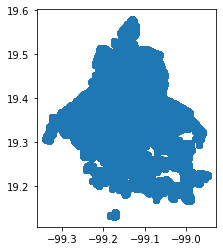

In [ ]:
datos_911 = gpd.GeoDataFrame(datos_911, 
                             geometry=gpd.points_from_xy(datos_911.longitud_centroide, 
                                                         datos_911.latitud_centroide))
datos_911 = datos_911.set_crs(epsg=4326)
datos_911.plot()

In [ ]:
datos_911.to_file("datos/descargas/datos_911.gpkg", layer='incidentes',driver="GPKG")

/home/plablo/miniconda3/envs/criminologia/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


De acuerdo a la documentación la columna manzana contiene el identficador de la manzana del incidente en las bases de INEGI. Unamos las bases de manzanas con las de incidentes para verificar

In [ ]:
manzanas = gpd.read_file("datos/descargas/manzanas_identificadores.gpkg")
unidos = datos_911.merge(manzanas, left_on='manzana', right_on='CVEGEO')
print( "Hay %s registros en la union "%(unidos.shape[0]))

Hay 2503230 registros en la union 


Estamos perdiendo muchos registros, puede ser que no estén bien las claves (¿corresponden a diferentes años?).

Entonces mejor hagamos una unión por centroides.

In [ ]:
unidos = (datos_911.sjoin(manzanas[['colonia_cve', 'colonia_nombre', 
                                  'cuadrante_id', 'geometry']].to_crs(unidos.crs))
         .drop(columns='index_right'))
print( "Hay %s registros en la union espacial"%(unidos.shape[0]))

Hay 3560134 registros en la union espacial


De todas formas se pierden registros, pero muchos menos, entonces vamos mejor a usar esta forma de unir.

Hasta aquí ya tenemos la base del 911 con identificadores de manzanas, colonias y cuadrantes. Sólo falta entonces procesar las fechas

In [ ]:
unidos['fecha_creacion'] = pd.to_datetime(unidos['fecha_creacion'], dayfirst=True)
unidos['fecha_creacion']

0         2020-07-02
6657      2020-07-03
25901     2020-07-12
45484     2020-07-09
48174     2020-07-17
             ...    
3681081   2019-07-18
3703218   2019-12-29
3704538   2019-12-29
3706709   2019-07-25
3707946   2019-07-25
Name: fecha_creacion, Length: 3560134, dtype: datetime64[ns]

Esta base ya está lista para usarse en la librería, la vamos a guardar comp pickle para recuperarla fácil

In [ ]:
unidos.to_pickle("datos/descargas/incidentes_911.pkl")

In [ ]:
unidos = pd.read_pickle("datos/descargas/incidentes_911.pkl")
type(unidos)

geopandas.geodataframe.GeoDataFrame

## Bases del DENUE

Para construir indicadores de uso de suelo vamos a incorporar las bases históricas del DENUE. El primer paso es descargarlas **todas** del sitio del INEGI. El sitio provee una herramienta para descrgar todos los datos usando Windows, para descargarlos desde Python, vamos a utilizar el XML que viene con dicha herramienta, este XML contiene las urls de todos los archivos que vamos a descargar, entonces el primer punto es _parsear_ el XML

In [ ]:
DOWNLOADS_PATH = "datos/descargas/denue/"
tree = ET.parse("datos/descargas/DescargaMasivaOD.xml")
root = tree.getroot()
datos = []
for archivo in root.iter('Archivo'):
    s = archivo.text
    tipo = s.rsplit("/")[-1].split(".")[-2].split("_")[-1]
    if tipo == 'shp' and (s.rsplit("/")[-2].split("_")[0] not in ['denue', 'esenciales']):
        url = archivo.text
        year = archivo.text.rsplit("/")[-2].split("_")[0]
        fname = s.rsplit("/")[-1]
        if os.path.exists(DOWNLOADS_PATH + fname):
            pass
        else:
            r = requests.get(url, allow_redirects=True)
            open(DOWNLOADS_PATH + fname, 'wb').write(r.content)
        try:
            gdf = gpd.read_file(DOWNLOADS_PATH + fname)
        except:
            zf = ZipFile('datos/descargas/denue/denue_00_11_0116_shp.zip')
            for f in zf.namelist():
                zinfo = zf.getinfo(f)
                if (zinfo.is_dir()):
                    if f.split("/")[-2] == 'conjunto_de_datos':
                        shps = [n for n in zf.namelist() if (n.startswith(f) and not n.endswith('/'))]
                        for s in shps:
                            basename = os.path.basename(s)
                            source = zf.open(s)
                            target = open(os.path.join('datos/descargas/denue/extracted/', basename), 'wb')
                            with source, target:
                                shutil.copyfileobj(source, target)
            gdf = gpd.read_file(os.path.join('datos/descargas/denue/extracted/', basename.split(".")[0] + '.shp'))
            [f.unlink() for f in Path('datos/descargas/denue/extracted/').glob("*") if f.is_file()] 
            
        campos = ['nom_estab', 'raz_social', 'codigo_act', 'nombre_act', 
                  'per_ocu', 'tipoCenCom', 'cve_ent', 'cve_mun', 'cve_loc', 
                  'ageb', 'manzana', 'geometry']
        gdf = gdf.loc[:,campos]
        gdf['cvegeo'] = gdf['cve_ent'] + gdf['cve_mun'] + gdf['cve_loc'] + gdf['ageb'] + gdf['manzana']
        gdf['year'] = year
        datos.append(gdf)
        
denue_total = pd.concat(datos)
denue_total.head()

,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipoCenCom,cve_ent,cve_mun,cve_loc,ageb,manzana,geometry,cvegeo,year
0,FUMIGACIONES GADI,None,115111,Servicios de fumigaciÃ³n agrÃ­cola,0 a 5 personas,None,26,055,0001,0323,004,POINT (-114.78062 32.47576),2605500010323004,2015
1,REGISAM KILL,None,115111,Servicios de fumigaciÃ³n agrÃ­cola,0 a 5 personas,None,22,014,0001,3346,017,POINT (-100.41023 20.64914),2201400013346017,2015
2,PESCA Y CAPTURA DE OTROS PECES CRUSTÃCEOS M...,None,114119,"Pesca y captura de peces, crustÃ¡ceos, molusco...",6 a 10 personas,None,03,001,0280,3171,011,POINT (-112.09794 24.78165),0300102803171011,2015
3,GRANJA PISCÃCOLA ELEAZAR,None,112512,"Piscicultura y otra acuicultura, excepto camar...",0 a 5 personas,None,17,024,0016,0154,046,POINT (-99.00873 18.63827),1702400160154046,2015
4,PESCA DE CAMARÃN,None,114111,Pesca de camarÃ³n,0 a 5 personas,None,25,009,0013,0379,031,POINT (-105.60270 22.69556),2500900130379031,2015


In [ ]:
denue_total.loc[denue_total.cve_ent == '09'].to_file("datos/salidas/denue_cdmx.shp")

/home/plablo/miniconda3/envs/criminologia/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
denue_total.columns

Index(['nom_estab', 'raz_social', 'codigo_act', 'nombre_act', 'per_ocu',
       'tipoCenCom', 'cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana',
       'geometry', 'cvegeo', 'year'],
      dtype='object')

AttributeError: No geometry data set yet (expected in column 'geometry'.)

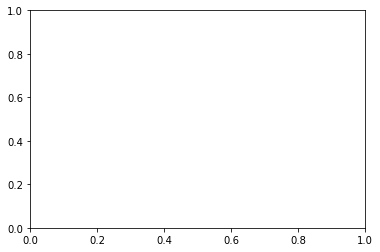

In [ ]:
datos[0].plot()